<a href="https://colab.research.google.com/github/sho-kaji/arcosaka/blob/master/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

準備

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 552, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 552 (delta 36), reused 61 (delta 31), pack-reused 479
Receiving objects: 100% (552/552), 17.80 MiB | 4.17 MiB/s, done.
Resolving deltas: 100% (295/295), done.


In [ ]:
cd pytorch_advanced

[Errno 2] No such file or directory: 'pose'
/content/pytorch_advanced/4_pose_estimation


In [ ]:
cd 4_pose_estimation

[Errno 2] No such file or directory: '4_pose_estimation'
/content/pytorch_advanced/4_pose_estimation


In [ ]:
import os
import urllib.request
import zipfile
import tarfile

In [ ]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [ ]:
# フォルダ「weights」が存在しない場合は作成する
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

# 画像データのアノテーションデータを整理したファイル「COCO.json」をダウンロードします。

フォルダ「data」に以下のデータを配置
アノテーションデータ「COCO.json」

https://www.dropbox.com/s/0sj2q24hipiiq5t/COCO.json?dl=0

# 画像中でアノテーション（人の関節位置の情報）がない人の部分をマスクするデータを用意します。

フォルダ「data」に以下のデータ「mask.tar.gz」を配置
マスクデータ「mask.tar.gz」

https://www.dropbox.com/s/bd9ty7b4fqd5ebf/mask.tar.gz?dl=0

# tensorboyさんによる、学習済みのOpenPoseモデル「pspnet50_30.pth」を用意します。

フォルダ「weights」に以下の「pose_model_scratch.pth」を配置
学習済みモデル「pose_model_scratch.pth」

https://www.dropbox.com/s/5v654d2u65fuvyr/pose_model_scratch.pth?dl=0
    

In [ ]:
# MSCOCOの2014 Val images [41K/6GB]をダウンロード
# 6GBのダウンロードと解凍なので時間がかかります（10分弱）
url =  "http://images.cocodataset.org/zips/val2014.zip"
target_path = os.path.join(data_dir, "val2014.zip") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    zip = zipfile.ZipFile(target_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ
  

In [ ]:
# mask.tar.gzの解凍
save_path = os.path.join(data_dir, "mask.tar.gz") 

with tarfile.open(save_path, 'r:*') as tar:
    tar.extractall(data_dir)

In [ ]:
Dataloderの作成

In [ ]:
# 必要なパッケージのimport
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

In [ ]:
# 必要なパッケージのimport
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision

ここから本番
OPENPOSEの学習

In [ ]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# 初期設定
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

DataLoader作成

In [ ]:
from utils.dataloader import make_datapath_list, DataTransform, COCOkeypointsDataset

# MS COCOのファイルパスリスト作成
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

# Dataset作成
# 本書ではデータ量の問題から、trainをval_listで作成している点に注意
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())

# 今回は簡易な学習とし検証データは作成しない
# val_dataset = CocokeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# DataLoader作成
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# val_dataloader = data.DataLoader(
#    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
# dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
dataloaders_dict = {"train": train_dataloader, "val": None}

ネットワークモデル作成

In [ ]:
from utils.openpose_net import OpenPoseNet
net = OpenPoseNet()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

損失関数を定義

In [ ]:
# 損失関数の設定
class OpenPoseLoss(nn.Module):
    """OpenPoseの損失関数のクラスです。"""

    def __init__(self):
        super(OpenPoseLoss, self).__init__()

    def forward(self, saved_for_loss, heatmap_target, heat_mask, paf_target, paf_mask):
        """
        損失関数の計算。

        Parameters
        ----------
        saved_for_loss : OpenPoseNetの出力(リスト)

        heatmap_target : [num_batch, 19, 46, 46]
            正解の部位のアノテーション情報

        heatmap_mask : [num_batch, 19, 46, 46]
            heatmap画像のmask

        paf_target : [num_batch, 38, 46, 46]
            正解のPAFのアノテーション情報

        paf_mask : [num_batch, 38, 46, 46]
            PAF画像のmask

        Returns
        -------
        loss : テンソル
            損失の値
        """

        total_loss = 0
        # ステージごとに計算します
        for j in range(6):

            # PAFsとheatmapsにおいて、マスクされている部分（paf_mask=0など）は無視させる
            # PAFs
            pred1 = saved_for_loss[2 * j] * paf_mask
            gt1 = paf_target.float() * paf_mask

            # heatmaps
            pred2 = saved_for_loss[2 * j + 1] * heat_mask
            gt2 = heatmap_target.float()*heat_mask

            total_loss += F.mse_loss(pred1, gt1, reduction='mean') + \
                F.mse_loss(pred2, gt2, reduction='mean')

        return total_loss


criterion = OpenPoseLoss()

最適化手法を設定

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=1e-2,
                      momentum=0.9,
                      weight_decay=0.0001)

学習を実施

In [ ]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    batch_size = dataloaders_dict["train"].batch_size

    # イテレーションカウンタをセット
    iteration = 1

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                optimizer.zero_grad()
                print('（train）')

            # 今回は検証はスキップ
            else:
                continue
                # net.eval()   # モデルを検証モードに
                # print('-------------')
                # print('（val）')

            # データローダーからminibatchずつ取り出すループ
            for imges, heatmap_target, heat_mask, paf_target, paf_mask in dataloaders_dict[phase]:
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                # issue #186より不要なのでコメントアウト
                # if imges.size()[0] == 1:
                #     continue

                # GPUが使えるならGPUにデータを送る
                imges = imges.to(device)
                heatmap_target = heatmap_target.to(device)
                heat_mask = heat_mask.to(device)
                paf_target = paf_target.to(device)
                paf_mask = paf_mask.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # (out6_1, out6_2)は使わないので _ で代替
                    _, saved_for_loss = net(imges)

                    loss = criterion(saved_for_loss, heatmap_target,
                                     heat_mask, paf_target, paf_mask)
                    del saved_for_loss
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 検証時
                    # else:
                        #epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, 0))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # 最後のネットワークを保存する
    torch.save(net.state_dict(), 'weights/openpose_net_' +
               str(epoch+1) + '.pth')

In [ ]:
    # 学習・検証を実行する
    num_epochs = 2
    train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 1/2
-------------
（train）
イテレーション 10 || Loss: 0.0093 || 10iter: 115.1525 sec.
イテレーション 20 || Loss: 0.0082 || 10iter: 88.1901 sec.
イテレーション 30 || Loss: 0.0068 || 10iter: 88.1268 sec.
イテレーション 40 || Loss: 0.0057 || 10iter: 86.6591 sec.
イテレーション 50 || Loss: 0.0048 || 10iter: 86.1209 sec.
イテレーション 60 || Loss: 0.0044 || 10iter: 89.8176 sec.
イテレーション 70 || Loss: 0.0037 || 10iter: 94.0262 sec.
イテレーション 80 || Loss: 0.0030 || 10iter: 91.5060 sec.
イテレーション 90 || Loss: 0.0027 || 10iter: 89.0366 sec.
イテレーション 100 || Loss: 0.0026 || 10iter: 89.2615 sec.
イテレーション 110 || Loss: 0.0021 || 10iter: 90.3482 sec.
イテレーション 120 || Loss: 0.0022 || 10iter: 89.4549 sec.
イテレーション 130 || Loss: 0.0020 || 10iter: 88.4074 sec.
イテレーション 140 || Loss: 0.0018 || 10iter: 88.6387 sec.
イテレーション 150 || Loss: 0.0019 || 10iter: 90.4877 sec.
-------------
epoch 1 || Epoch_TRAIN_Loss:0.0043 ||Epoch_VAL_Loss:0.0000
timer:  1427.2806 sec.
-------------
Epoch 2/2
-------------
（train）
イテレーション 160 || Loss: 0.00

姿勢推定の実行

In [ ]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [ ]:
from utils.openpose_net import OpenPoseNet

# 学習済みモデルと本章のモデルでネットワークの層の名前が違うので、対応させてロードする
# モデルの定義
net = OpenPoseNet()

# 学習済みパラメータをロードする
net_weights = torch.load(
    './weights/pose_model_scratch.pth', map_location={'cuda:0': 'cpu'})
keys = list(net_weights.keys())

weights_load = {}

# ロードした内容を、本書で構築したモデルの
# パラメータ名net.state_dict().keys()にコピーする
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]
                 ] = net_weights[list(keys)[i]]

# コピーした内容をモデルに与える
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


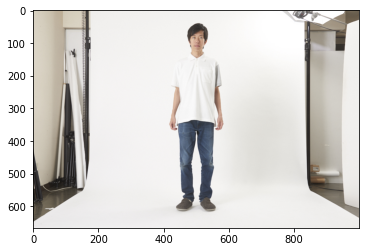

In [ ]:
# 草野球の画像を読み込み、前処理します

test_image = './data/1_3lights_standard.jpg'
oriImg = cv2.imread(test_image)  # B,G,Rの順番

# BGRをRGBにして表示
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 画像のリサイズ
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 画像の前処理
img = img.astype(np.float32) / 255.

# 色情報の標準化
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

# 21/03/07 Issue147 https://github.com/YutaroOgawa/pytorch_advanced/issues/147
# 色チャネルの順番を誤っています
# preprocessed_img = img.copy()[:, :, ::-1]  # RGB→BGR
preprocessed_img = img.copy()  # RGB

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

# （高さ、幅、色）→（色、高さ、幅）
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 画像をTensorに
img = torch.from_numpy(img)

# ミニバッチ化：torch.Size([1, 3, 368, 368])
x = img.unsqueeze(0)

# OpenPoseでheatmapsとPAFsを求めます
net.eval()
predicted_outputs, _ = net(x)

# 画像をテンソルからNumPyに変化し、サイズを戻します
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(
    pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(
    heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)


In [ ]:
from utils.decode_pose import decode_pose
a, result_img, b, c = decode_pose(oriImg, heatmaps, pafs)

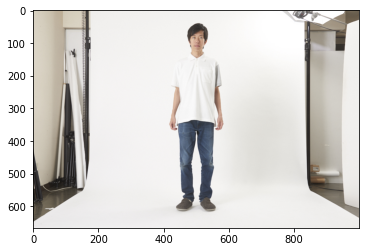

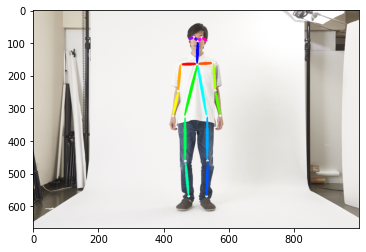

In [ ]:
# 結果を描画
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()

In [ ]:
print(a)

[[[216 210 194]
  [215 208 192]
  [217 210 194]
  ...
  [114 102  86]
  [113 102  84]
  [113 102  82]]

 [[215 209 193]
  [216 210 194]
  [216 209 193]
  ...
  [113 102  84]
  [114 103  85]
  [113 101  85]]

 [[215 209 193]
  [213 210 193]
  [216 210 194]
  ...
  [113 102  84]
  [112 104  85]
  [109 102  83]]

 ...

 [[236 234 235]
  [235 233 234]
  [233 233 233]
  ...
  [236 235 233]
  [239 238 236]
  [237 236 234]]

 [[237 235 236]
  [236 234 235]
  [236 236 236]
  ...
  [238 237 235]
  [238 237 235]
  [238 237 235]]

 [[235 235 235]
  [235 235 235]
  [236 236 236]
  ...
  [236 235 233]
  [237 236 234]
  [238 237 235]]]


In [ ]:
print(b)

[[506.          94.           0.93403858   0.           0.        ]
 [503.         164.           0.87760258   1.           1.        ]
 [452.         166.           0.88045847   2.           2.        ]
 [445.         248.           0.94104397   3.           3.        ]
 [429.         323.           0.86796242   4.           4.        ]
 [552.         162.           0.87716913   5.           5.        ]
 [559.         246.           0.93505907   6.           6.        ]
 [574.         322.           0.94592893   7.           7.        ]
 [465.         327.           0.70998996   8.           8.        ]
 [467.         462.           0.78773928   9.           9.        ]
 [477.         569.           0.88164586  10.          10.        ]
 [533.         325.           0.74013513  11.          11.        ]
 [535.         461.           0.80322516  12.          12.        ]
 [532.         569.           0.88776124  13.          13.        ]
 [492.          83.           0.91173041  14.   

In [ ]:
print(c)

[[ 0.          1.          2.          3.          4.          5.
   6.          7.          8.          9.         10.         11.
  12.         13.         14.         15.         16.         17.
  32.40516949 18.        ]]
